# Importar bibliotecas e dados / Criar classe

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy import stats

from math import factorial


In [2]:
df = pd.read_csv("SENIC.csv")
df.head()

,id,tempo,idade,risco_infeccao,cultura,x_ray,numero_camas,afiliacao,regiao,census,enfermeiras,servicos
0,1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
1,2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
2,3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
3,4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
4,5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0


In [3]:
class Multiple_Regression:
    def __init__(self, data : "dataframe", attributes : list, target : str, categorize = False, category = None):
        self.df = data
        self.features = attributes
        self.dict_features = {i: feat for i, feat in enumerate(['intercept'] + self.features)}
        self.categorize = categorize
        self.target = target
        if(categorize):
            self.category = category
            self.groups = data[category].sort_values().unique()
            self.model_SMF = smf.ols(formula=self.define_formula(), data=self.df).fit()

        self.X = self.get_data(categorize = False)
        self.XTX_inv = np.linalg.inv(self.X.T @ self.X)
        self.H = self.X @ self.XTX_inv @ self.X.T
        self.Y = self.df[target]
        self.residual = None
        
        self.model_SKL = self.MR_SKL()
        self.results = self.get_results()
        self.stats = self.stats_model()
        
    def define_formula(self):
        model = self.target + ' ~ '
        for feat in self.features:
            model += feat + ' + '
        if type(self.df[self.category][0]) != str:
            model += 'C(' + self.category + ')'
        else : model += self.category
        return model
    
    def categ_data(self, data, category = None):  
        data_dict = {}
        
        for group in self.groups:
            data_dict[group] = data.loc[data[category] == group]
        return data_dict

    def get_data(self, categorize = False, categories = None):
        if categorize:
            matrix_dict = {}
            
            if categories == None or categories == 'all':
                groups = self.groups
            else:
                groups = categories
                
            for group in groups:
                predictors = self.df.loc[df[self.category] == group][self.features]
                X = np.concatenate([np.ones((predictors.shape[0], 1)), predictors], axis=1)
                
                XTX_inv = np.linalg.inv(X.T @ X)
                H = X @ XTX_inv @ X.T
                Y = self.df.loc[df[self.category] == group][self.target]
                
                y_hat = H @ Y
                I_H = (np.eye(X.shape[0]) - H)
                residuals = I_H @ Y 
                
                beta_hat = XTX_inv @ X.T @ Y
                
                matrix_dict[group] = {'X' : X,
                                      'XTX_inv' : XTX_inv,
                                      'H' : H,
                                      'Y' : Y,
                                      'y_hat' : y_hat,
                                      'e' : residuals,
                                      'b_hat' : beta_hat}
            return matrix_dict
        
        predictors = self.df[self.features]
        predictors = np.concatenate([np.ones((predictors.shape[0], 1)), predictors], axis=1)
        return predictors
            
    def MR_SKL(self):
        # X_SK = sm.add_constant(df_model_A) 
        model = sm.OLS(self.Y, self.X).fit() 
        return model
    
    def summary_SKL(self):
        display(self.model_SKL.summary())
    
    def summary_SMF(self, ANOVA = False, Summary = False):
        if (Summary): display(self.model_SMF.summary())
        if(ANOVA): display(sm.stats.anova_lm(self.model_SMF, typ=2))
    
    def get_results(self):
        results = {}

        beta_hat = self.XTX_inv @ self.X.T @ self.Y
        I_H = (np.eye(self.X.shape[0]) - self.H)
        J = np.ones(self.X.shape[0])
        n = self.X.shape[0]
        p = self.X.shape[1] - 1
        
        # e = (I - H) @ Y
        e = I_H @ self.Y
        
        # SSR = Y.T @ [H - J/N) @ Y 
        SSR = self.Y.T @ (self.H - J/self.X.shape[0]) @ self.Y
        # SSE = Y.T @ (I - H) @ Y = Y.t @ e 
        SSE = self.Y.T @ e
        SST = SSR + SSE
        
        if(p == 1) : p += 1
        MSR = SSR / (p - 1)
        MSE = SSE / (n - p)

        # Covariance matrix - principal diagonal gives S^2
        cov_matrix = MSE * self.XTX_inv
        se_matrix = np.sqrt(np.diag(cov_matrix))     
        
        r_squared = 1 - (SSE / SST)
        F_obs = MSR / MSE 
        p_values = beta_hat / se_matrix
        
        results['beta_hat'] = beta_hat
        results['SE'] = se_matrix
        results['SS'] = { "SSR" : SSR, "SSE" : SSE, "SST" : SST}
        results['MS'] = {"MSR" : MSR, "MSE" : MSE}
        results['Stats'] = {'r^2' : r_squared, 'F' : F_obs, 'pval' : p_values}
        
        self.residuals = e
        
        return results
    
    def plot_results(self, type_plot, *args, **kwargs):
        if type_plot == 'scatter':
            self.__plot_scatter(*args, **kwargs)
        elif type_plot == 'residuals':
            self.__plot_residuals(*args, **kwargs)
        elif type_plot == 'qq':
            self.__qq_plot(*args, **kwargs)
        else:
            print("Invalid plot type. Supported types: 'scatter', 'residuals', 'qq'")
    
    def check_categories(self, categories : list):
        if categories == 'all':
            return True
            
        s = set(self.groups)
        s1 = set(categories)

        if not s1.issubset(s):
            print("Invalid categories!\n")

        return s1.issubset(s)
        
    def __plot_scatter(self, categories = None, plot_size=(4, 4)):
        if categories and not self.check_categories(categories): return None
        
        def plot(df, title):
            g = sns.pairplot(df[self.features], diag_kind='kde', height=plot_size[1], aspect=plot_size[0]/plot_size[1])
            g.map_upper(sns.kdeplot, fill=True, thresh=0, levels=100, cmap="mako")
            g.map_lower(sns.regplot, color=".3", line_kws=dict(color="r"))
            g.fig.suptitle(title, y=1.02)
    
        if categories:
            if (categories == 'all') and (self.categorize):
                categories = self.df[self.category].sort_values().unique()
            for categ in categories:
                plot(self.dict_categ[categ], title=f"Análise features - {self.category.title()} {categ}")
                plt.show() 
        else:
            plot(self.df, title="Análise features")
            plt.show()
    
    def __plot_residuals(self, categories = None):
        if categories and not self.check_categories(categories): return None
        
        def __plot_res(Y_hat, Residuals, X, Results, Category):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.scatter(Y_hat, Residuals, alpha=0.8)
            
            plt.axhline(y=0, color='r', linestyle='--')

            title = 'Resíduos - ' 
            if categories: title = title + 'Região ' + str(Category)
            else: title = title + Category
            plt.title(title)
            plt.xlabel('Ŷ (Resposta ajustada)')
            plt.ylabel('Resíduos')
            
            plt.subplot(1, 2, 2)
            
            for i in range(1, X.shape[1]):
                plt.scatter(X[:, i], Residuals, label=f'X{i} = {self.dict_features[i]}', alpha=0.8)
            
            plt.axhline(y=0, color='r', linestyle='--')
            title = r"$\hat{Y} = "
            for i, var in enumerate(Results):
                if i:
                    title = title + f"{var : .2f}" + r"*X" + f"{i}"
                    if(i < len(Results) - 1):
                         title = title + " +"
                else: title = title + f"{var : .2f} +"
            
            plt.title(title + "$")
            plt.xlabel('Valor da variável preditora')
            plt.ylabel('Resíduos')
            plt.legend(bbox_to_anchor = (1,1))
            
            plt.tight_layout()
            plt.show()

        if categories: 
            categ_dict = self.get_data(categorize = True, categories = categories)
            for categ, data in categ_dict.items():
              __plot_res(Y_hat = data['y_hat'], Residuals = data['e'], X = data['X'], Results = data['b_hat'], Category = categ)
        else : __plot_res(Y_hat = self.H @ self.Y, Residuals = self.residuals, X = self.X, Results = self.results['beta_hat'], Category = 'Todas as regiões')
            
       

    def __qq_plot(self, categories = None):
        if categories and not self.check_categories(categories): return None
        
        def __qq(Residuals, Category):
            plt.figure(figsize=(6, 6))
            stats.probplot(Residuals, dist="norm", plot=plt)
    
            sm.qqline(plt.gca(), line='45', fmt='r--', alpha=0.5, color = "green", label='Distribuição Normal')
            plt.gca().set_xlim([-3, 3])
            
            plt.axhline(y=1000, color='red', label='Dados')
            
            title = 'QQ plot Resíduos - ' 
            if categories: title = title + 'Região ' + str(Category)
            else: title = title + Category
            
            plt.title(title)
            plt.legend()
            plt.show()
        
        if categories:
            categ_dict = self.get_data(categorize = True, categories = categories)
            for categ, data in categ_dict.items():
              __qq(Residuals = data['e'], Category = categ)
        else : __qq(Residuals = self.residuals, Category = 'Todas as regiões')
            
            
    def stats_model(self):
        stats_dict = {}
        dof = len(self.df) - 1
        alpha = 0.05
        
        for i, beta in enumerate(self.results['beta_hat']):
            se = self.results['SE'][i]
            
            t_obs = beta/se
            p = (1 - stats.t.cdf(x = abs(t_obs), df = dof)) * 2
            
            t_ic = stats.t.ppf((1 - 0.5*alpha), df = dof)
            IC = (beta - t_ic*se, beta + t_ic*se)
            stats_dict[i] = [beta, se, t_obs, p, IC]
        
        return stats_dict
    
    def Y_hat(self, model = ""):
        Y_hat = "Ŷ = "
        for i, beta in enumerate(self.results['beta_hat']):
            Y_hat += f"{beta:.3f}"
            if i:
                if(i < len(self.results['beta_hat']) - 1) : Y_hat += f"*X{i} + "
                else: Y_hat += f"*X{i}"
            else: Y_hat += " + "
        return model + Y_hat
    
    # Stats_possible: ['Y_hat', 'StdErr', 'MS', 'Stats']
    def get_stats(self, model = "", stats = None):
        dict_stats = {}
            
        Y_hat = model + "Ŷ = "
        for i, beta in enumerate(self.results['beta_hat']):
            Y_hat += f"{beta:.3f}"
            if i:
                if(i < len(self.results['beta_hat']) - 1) : Y_hat += f"*X{i} + "
                else: Y_hat += f"*X{i}"
            else: Y_hat += " + "
    
        StdErr = model + "SE:\n"
        for i, se in enumerate(self.results['SE']):
            StdErr += f"B{i}:\t{se:.3f}\n"
        
        Stats = model + "Stats:\n"
        Stats += f"r²:\t{self.results['Stats']['r^2']:.3f}"
        
        Stats += f"\nP_valores:\n"
        for i, p in enumerate(self.results['Stats']['pval']):
            Stats += f"X{i}:\t{p:.3f}\n"
        
        dict_stats['Y_hat'] = Y_hat
        dict_stats['StdErr'] = StdErr
        dict_stats['MS'] = model + f"\nMSR:\t{self.results['MS']['MSR'] :.3f}\nMSE:\t{self.results['MS']['MSE']:.3f}"
        dict_stats['Stats'] = Stats
    
        if(stats):
            print("")
            for stat in stats:
                print(dict_stats[stat])
        else:
            print("")
            for statistics in dict_stats.values():
                print(statistics)
  
def get_label(pca, lr):

    title = r"$\hat{X} = "
    for i, var in enumerate(pca):
        title = title + f"{var : .2f}" + r"*X" + f"{i}"
        if(i < len(pca) - 1):
             title = title + " +"


    title_y = r"$\hat{Y} = "
    for i, var in enumerate(lr):
        if i:
            title_y = title_y + f"{var : .2f}" + r"*X" + f"{i}"
            if(i < len(lr) - 1):
                 title_y = title_y + " +"
        else: title_y = title_y + f"{var : .2f} +"
        
    return title + "$\n" + title_y + "$"

def plot_corr(data, variables):
    if(variables): data = data[variables]
    
    fig, axs = plt.subplots(1, 2, figsize=(20,7))
    fig.suptitle("Distribuição das variáveis")
       
    corr_pearson = data.corr(method='pearson')
    corr_spearman = data.corr(method='spearman')
    
    ax = axs[0]
    sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title("Matriz de Correlação de Pearson")
    
    ax = axs[1]
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title("Matriz de Correlação de Spearman")
    
    plt.tight_layout()
    
def total_combinations(sample_size):
    def calculate_combinations(n, r):
        return factorial(n) / (factorial(r) * factorial(n - r))
    
    total = 0
    for r in range(1, sample_size + 1):
        total += calculate_combinations(sample_size, r)
    return int(total)

def get_predictor_offset(n_features : int, params : list):  
    n_categ = len(df.regiao.unique())
    pred_matrix = []
    for i in range(n_categ):
        pred = [params[i]] 
        for j in range(0, n_features - 1):
            pred.append(params[j + n_categ])
        pred_matrix.append(pred)
        if (i): pred_matrix[i][0] += pred_matrix[0][0]
        
    pred_matrix = np.array(pred_matrix)
    return pred_matrix

def get_predictor(n_features : int, params : list):  
    n_var = total_combinations(n_features - 1) + 1
    n_categ = len(df.regiao.unique())
    pred_matrix = []
    for i in range(n_categ):
        pred = [] 
        for j in range(n_var):
            pred.append(params[i + j * n_categ])
        pred_matrix.append(pred)
    
    pred_matrix = np.array(pred_matrix)
    
    for i in range(1, n_categ):
        pred_matrix[i] += pred_matrix[0]

    return pred_matrix

def get_features(features : list):
    data = features.drop('regiao', axis = 1).copy()
    data = np.array(data)
    
    labels = []
    matrix = []
    n_var = len(data[0])
    
    l_base = ['']
    
    for i in range (0, n_var):
        l_base.append('X' + str(i+1) + l_base[0])
        l_atual = l_base[len(l_base) - 1]

        for j in range(0,len(l_base) - 2):
            l_base.append(l_base[j+1] + l_atual)
    labels.append(l_base)


    for obs in range(len(data)):
        X_i = []
        L_i = []
        aux = 0
        
        # identificador variavel dummy
        if(obs):
            l_feat = 'X' + str(obs + n_var)
            L_i.append(l_base[aux] + l_feat)
            aux += 1
        for i in range (0, n_var):
            if(obs):
                L_i.append(l_base[aux] + l_feat)
                aux += 1

            X_i.append(data[obs][i])
            x_atual = X_i[len(X_i) - 1]
            for j in range(0,len(X_i) - 1):
                if(obs):
                    L_i.append(l_base[aux] + l_feat)
                    aux += 1
                X_i.append(X_i[j] * x_atual)
        X_i.insert(0,1)
        matrix.append(X_i)
        if obs: labels.append(L_i)

    for obs in range(len(data)):
        y_hat = ""
        for var in range(len(labels[0])):
            y_hat += f"{int(matrix[obs][var])}" + labels[obs][var]
            if(var < len(labels[0]) - 1):  y_hat += ' + '
    
    return matrix, labels

def get_predictor_simple(n_features : int, params : list):  
    n_categ = len(df.regiao.unique())
    pred_matrix = []
    for i in range(n_categ):
        pred = [] 
        for j in range(n_features):
            pred.append(params[i + j * n_categ])
        pred_matrix.append(pred)
    
    pred_matrix = np.array(pred_matrix)
    for i in range(1, n_categ):
        pred_matrix[i][0] += pred_matrix[0][0]

    return pred_matrix

def get_features_simple(features : list):
    data = features.drop('regiao', axis = 1).copy()
    data = np.array(data)
    
    labels = []
    matrix = []
    n_var = len(data[0])
    
    l_base = ['']
    
    for i in range (0, n_var):
        l_base.append('X' + str(i+1) + l_base[0])
    labels.append(l_base)

    for obs in range(len(data)):
        X_i = []
        L_i = []
        aux = 0

        # identificador variavel dummy
        if(obs):
            l_feat = 'X' + str(obs + n_var)
            L_i.append(l_base[aux] + l_feat)
            aux += 1
            
        for i in range (0, n_var):
            if(obs):
                L_i.append(labels[0][aux] + l_feat)
                aux += 1
            X_i.append(data[obs][i])

        X_i.insert(0,1)
        matrix.append(X_i)
        if obs: labels.append(L_i)
    
    # print(labels)

    for obs in range(len(data)):
        y_hat = ""
        for var in range(len(labels[0])):
            y_hat += f"{int(matrix[obs][var])}" + labels[obs][var]
            if(var < len(labels[0]) - 1):  y_hat += ' + '
    
    return matrix, labels
    
def predict(features : 'dataframe', params : list, interactions = True, offset = False, prt_res = False):
    if (interactions):
        pred = get_predictor(len(features.iloc[0]), params)
        feat, labels = get_features(features)
    else:
        if(offset): pred = get_predictor_offset(len(features.iloc[0]), params)
        else: pred = get_predictor_simple(len(features.iloc[0]), params)
        feat, labels = get_features_simple(features)
    n_categ = len(df.regiao.unique())
    
    if(prt_res):
        for i in range(len(features)):
            categ = features.iloc[i][-1] - 1
            print(feat[i] @ pred[categ].T)
    
    dict_hat = {}
    for i,categ in enumerate(pred):
        y_hat = ""
        for j, elem in enumerate(categ):
            y_hat += f"{elem:.5f} " + labels[i][j] + ' + '
        dict_hat['Regiao ' + str(i + 1)] = y_hat[:-3]
        
    return pred, dict_hat

def get_formula(df, target, features, categoric_feat, interactions = True, offset = False):
    if(interactions and offset) : offset = False
    if type(df[categoric_feat][0]) != str:
        categ_feat = 'C(' + categoric_feat + ')'
    else : categ_feat = categoric_feat
    
    model = target + ' ~ '
    for feat in features:
        if(interactions): model += feat + '*'
        else:
            if(offset): model += feat + ' + '  
            else: model += feat + '*' + categ_feat + ' + '    

    if (interactions or offset) :
        model += categ_feat
    else:
        model = model[:-3]
    return model

def get_data(target, features, categoric):
    idade = [1, 1, 1 ,1, 2]
    cultura = [1, 1, 1 ,1, 10]
    census = [1, 1, 1 ,1, 5]
    servicos = [1, 1, 1 ,1, 8]
    enfermeiras = [1, 1, 1 ,1, 10]
    regiao = [1, 2, 4, 3, 2]
    
    # idade = [30, 40, 25, 50]
    # cultura = [100, 90, 120, 60]
    # census = [10, 1, 10, 6]
    # servicos = [5, 7, 1, 10]
    # enfermeiras = [-5, -7, 1, 8]
    # regiao = [1, 2, 3, 4]
    
    data_dict = {}
    for feature in features:
        data_dict[feature] = locals()[feature]
    data_dict[categoric] = regiao
    new_data = pd.DataFrame(data_dict)
    return new_data

def show_tp(model):
    print("Interpretação p-valor com base estatística t-student (alpha = 0.05)")
    signif = model.pvalues[model.pvalues < 0.05]
    non_signif = model.pvalues[model.pvalues >= 0.05]
    print("Features significativas: ", signif.index.tolist())
    print("Features não significativas: ", non_signif.index.tolist(), "\n")
    # return signif, non_signif

def show_Fp(model):
    print(r"Interpretação p-valor com base estatística F (alpha = 0.05)")
    anova = sm.stats.anova_lm(model, typ=2)
    signif = anova[anova['PR(>F)'] < 0.05]
    non_signif = anova[anova['PR(>F)'] >= 0.05]
    print("Features significativas: ", signif.index.tolist())
    print("Features não significativas: ", non_signif.index.tolist(), "\n")

def report_regression(verbose = True, check_results = False, interactions = False, offset = False, **kwargs):
    df = kwargs.get('df')
    target = kwargs.get('target')
    features = kwargs.get('features')
    categoric = kwargs.get('categoric')
    
    model_formula = get_formula(df, target, features, categoric, interactions = interactions, offset = offset)
    modelo = smf.ols(formula=model_formula, data=df).fit()
    params = modelo.params
    
    coefficients, regression = predict(new_data, params, interactions = interactions, offset = offset, prt_res = check_results)
    
    st_model, st_categ, err_model = stats_categorical(modelo, df, features + [categoric], target)
    
    print(model_formula)
    
    if(check_results):
        print("Resultados statsmodel (amostra aleatoria):\n")
        display(modelo.predict(new_data))

    
    print("\nFunção de regressão por região:")
    display(regression)

    if(verbose):
        print(st_model)
        print(f"Porcentagem dos erros por região:")
        percent_categ = []
        for categ, stts_categ in st_categ.items():
            percent_categ.append((stts_categ[0] / st_model['SSE'], categ))
            print(f"Reg. {categ}:\t{percent_categ[categ - 1][0]:.2f}")
    
        print("{ Regiao : [SSE_regiao", "MSE_regiao", "R²_regiao]}")
        display(st_categ)
    print(f"\nEstatísticas Resumidas:\nMSE - Regressão:\t{modelo.mse_model:7.3f},\nMSE - Resíduos:\t\t{modelo.mse_resid:7.3f},\nR²:\t\t\t\t\t{modelo.rsquared:7.3f}\n")
    
    if(verbose):
        # show_tp(modelo)
        show_Fp(modelo)
    
    return coefficients, regression, err_model

def stats_categorical(modelo, data, features, target):
    
    X = data[features]
    Y = data[target]

    stats_regiao = { }
    p = len(modelo.params)
    n = len(data)

    SSE = 0
    err_data = []
    
    for reg in data.regiao.sort_values().unique():
        selected_indexes = df.loc[df['regiao'] == reg].index
        e = modelo.resid.loc[selected_indexes]
        err_data.append(e)
        y_reg = Y.loc[selected_indexes]
        I = np.eye(len(selected_indexes)) 
        J = np.ones(len(selected_indexes))   
        sst_regiao = y_reg.T @ (I - J/len(selected_indexes)) @ y_reg
        sse_regiao = e.T @ e
        stats_regiao[reg] =  [sse_regiao, sse_regiao/(n-p), 1 - (sse_regiao/sst_regiao)]
        SSE += sse_regiao
        
    I = np.eye(X.shape[0]) 
    J = np.ones(X.shape[0]) 
    sst_regiao = Y.T @ (I - J/X.shape[0]) @ Y
    MSE = SSE/(n-p)
    stats_modelo = {'SSE' : SSE, 'MSE' : MSE, 'R²' : 1 - (SSE/sst_regiao)}
    # print(MSE)
    return stats_modelo, stats_regiao, err_data

def qq_plot_cat(df, residual):
        
        def __qq(Residuals, Category):
            plt.figure(figsize=(6, 6))
            stats.probplot(Residuals, dist="norm", plot=plt)
    
            sm.qqline(plt.gca(), line='45', fmt='r--', alpha=0.5, color = "green", label='Distribuição Normal')
            plt.gca().set_xlim([-3, 3])
            
            plt.axhline(y=1000, color='red', label='Dados')
            
            title = 'QQ plot Resíduos - Regiao' + str(Category)
            
            title = title 
            plt.title(title)
            plt.legend()
            plt.show()
        

        for i, categ in enumerate(df.regiao.sort_values().unique()):
            print(i)
            __qq(Residuals = residual[i], Category = categ)

In [4]:
model_A = ['idade', 'risco_infeccao', 'servicos']
MR_A = Multiple_Regression(data = df, attributes = model_A, target = 'tempo')

model_B = ['numero_camas', 'risco_infeccao', 'servicos']
MR_B = Multiple_Regression(data = df, attributes = model_B, target = 'tempo')

model_3 = ['idade', 'numero_camas', 'risco_infeccao', 'servicos']
MR_3 = Multiple_Regression(data = df, attributes = model_3, target = 'tempo')

model_3b = ['servicos']
MR_3b = Multiple_Regression(data = df, attributes = model_3b, target = 'tempo')

features = ['idade',  'cultura', 'census', 'servicos']
target = 'tempo'
categoric = 'regiao'
new_data = get_data(target, features, categoric)

# modelo_total.predict(new_data) # Conferir resultado com statsmodel

***
***
***

# Exercício 2

Modelo A = **Idade do paciente**, Probabilidade do risco de infecção e Porcentagem de serviços fornecidos.

Modelo B = **Número de leitos**, Probabilidade do risco de infecção e Porcentagem de serviços fornecidos.

***

## a)

É possível observar na figura abaixo, relativa ao Modelo A, que as únicas variáveis com correlação significativa são serviços x risco de infecção. A variável idade mostra-se pouco correlacionada com as outras duas variáveis. Além disso, nota-se que as variáveis tem distribuição aproximadamente simétrica em todos os casos.

C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


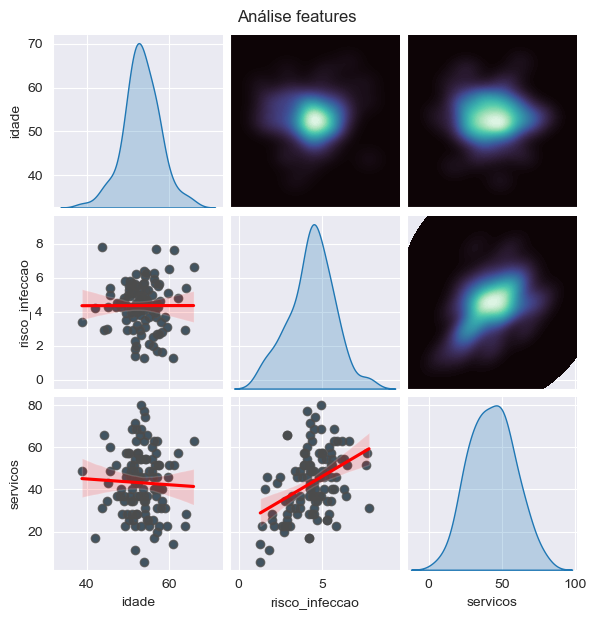

In [5]:
MR_A.plot_results(type_plot="scatter", plot_size = (2,2))

Na imagem abaixo (referente ao Modelo B) é possível observar que todas as variáveis apresentam considerável correlação entre si, evidenciado pela linha vermelha nos scatter plots, ou seja, a troca da feature idade pela feature número de leitos resultou que todas as covariáveis guardam certa correlação entre si. Além disso, é válido destacar que a distribuição da feature "número de leitos" apresentam certa assimetria, com os valores concentrados entre o intervalo [0, 500].

C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


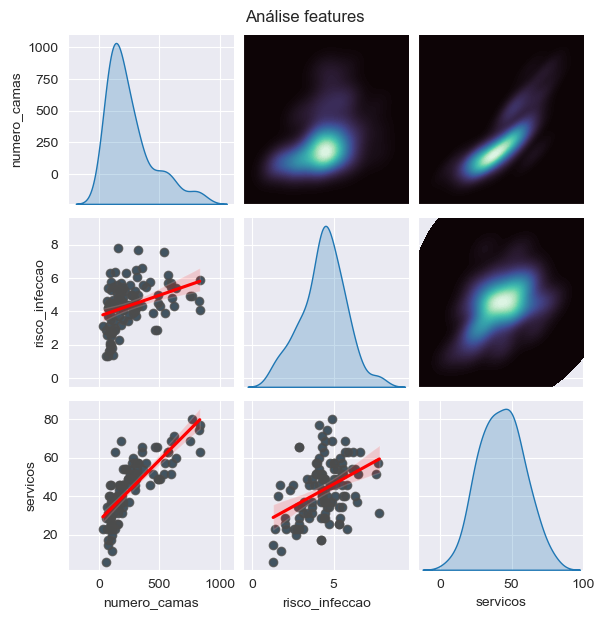

In [6]:
MR_B.plot_results(type_plot="scatter", plot_size = (2,2))

***

## b) & c)

Abaixo são relacionados os modelos de regressão linear múltipla para cada um dos casos:

In [7]:
MR_A.get_stats(model="Modelo A: ", stats=['Y_hat']), MR_B.get_stats(model="Modelo B: ", stats=['Y_hat'])


Modelo A: Ŷ = 1.386 + 0.084*X1 + 0.658*X2 + 0.022*X3

Modelo B: Ŷ = 6.467 + 0.003*X1 + 0.648*X2 + -0.009*X3


(None, None)

In [8]:
MR_A.model_SKL.summary(), MR_B.model_SKL.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  tempo   R-squared:                       0.345
 Model:                            OLS   Adj. R-squared:                  0.327
 Method:                 Least Squares   F-statistic:                     19.12
 Date:                Thu, 07 Dec 2023   Prob (F-statistic):           4.93e-10
 Time:                        18:04:00   Log-Likelihood:                -209.16
 No. Observations:                 113   AIC:                             426.3
 Df Residuals:                     109   BIC:                             437.2
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

Além disso, acima são relacionados os valores de R², que em ambos os casos ficou em torno de 0.34, portanto, tomando como critério o coeficiente R², ambos so modelos performam de forma similar.
***

## d)

Abaixo são exibidos os resíduos em função da resposta ajustada de Ŷ, além de realizar a representação dos resíduos em relação à cada uma das variáveis, no plot da direita.

Nos dois modelos, A e B, é possível observar uma distribuição relativamente uniforme tanto ao longo dos diferentes valores de Ŷ, característico de resíduos com distribuição normal. Além disso, tanto para Ŷ quanto para as variávies X1, X2 e X3 observa-se um comportamento relativamente simetrico em relação à 0.

Modelo A


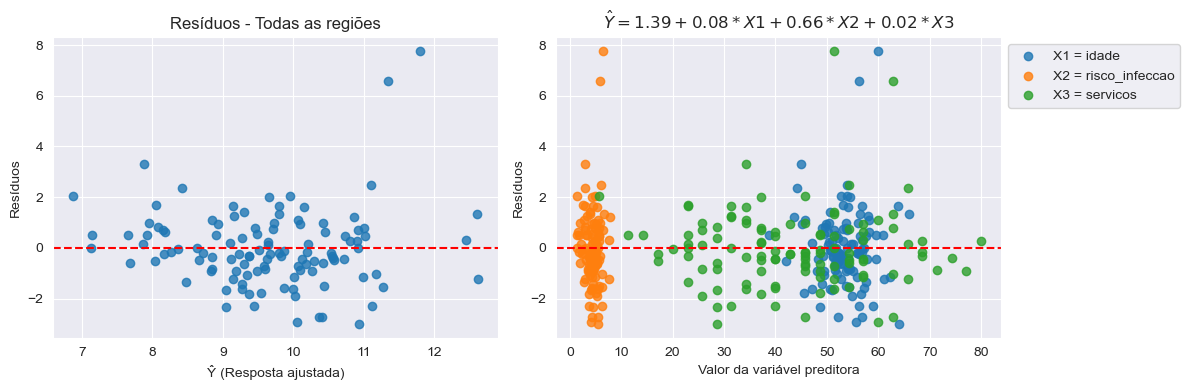

In [9]:
print('Modelo A')
MR_A.plot_results(type_plot="residuals")

Modelo B


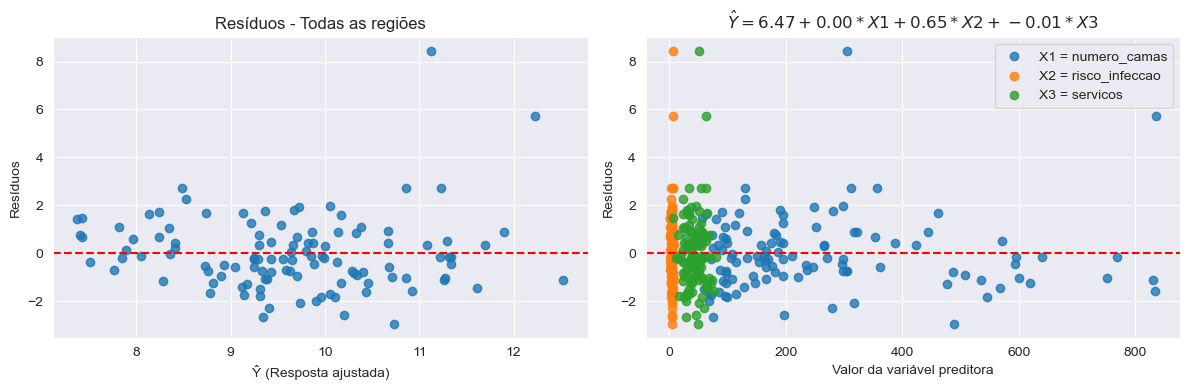

In [10]:
print('Modelo B')
MR_B.plot_results(type_plot="residuals")

***

## e)

Abaixo são plotados os QQ plots para ambos os modelos, com a linha verde sendo relativa a uma distribuição normal e a linha vermelha fitada nos dados, sendo evidente o coportamento similar de ambos os modelos.

Modelo A


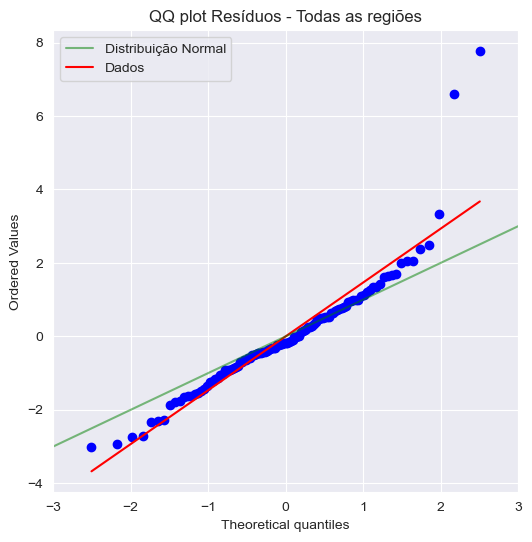

Modelo B


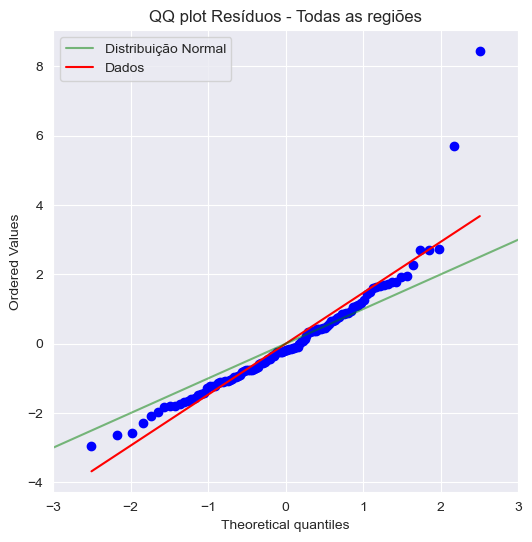

In [11]:
print("Modelo A")
MR_A.plot_results(type_plot='qq')
print("Modelo B")
MR_B.plot_results(type_plot='qq')

***
***
***

# Exercício 3

Modelo 3 = Idade do paciente, Número de leitos, Probabilidade do risco de infecção e Porcentagem de serviços fornecidos.

Modelo 3b = Porcentagem de serviços fornecidos.

***

## a)
Na matriz de correlação abaixo é possível observar que, tanto no caso da Correlação de Pearson quanto na Correlação de Sprearman, as variáveis com correlação moderada/forte seriam serviços e número de camas, o que é razoável uma vez que hospitais maiores prestam maior número de serviços e contam com maior quantidade de leitos disponíveis.

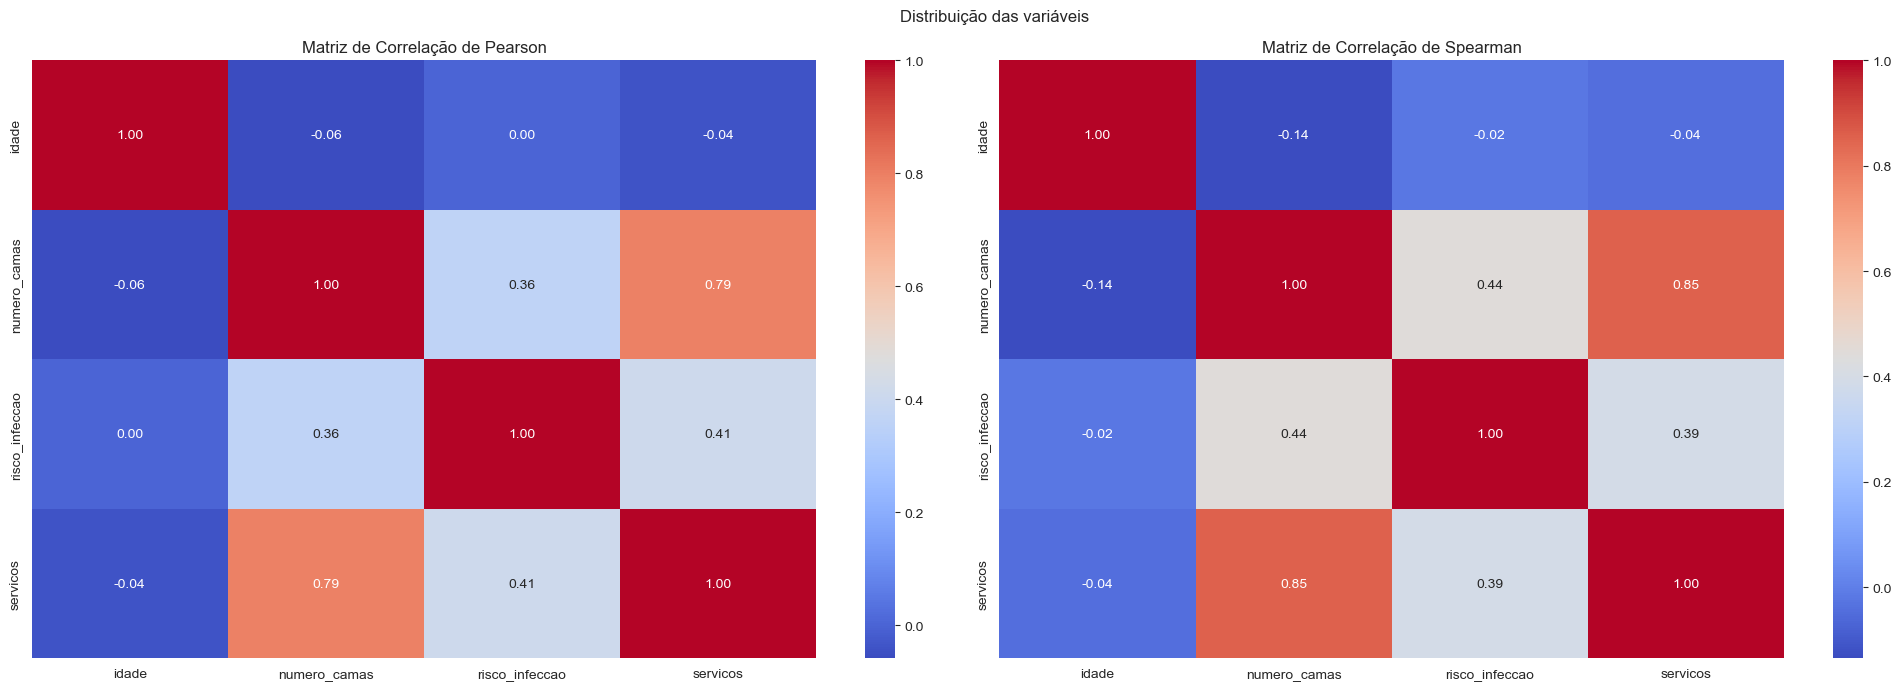

In [12]:
plot_corr(df, variables=model_3)

***
## b)

Abaixo é exibido o modelo somente com a variável "Porcentagem de serviços prestados", bem como o erro padrão associado a cada um dos estimadores.

In [13]:
(MR_3b.get_stats(model="Modelo 3b: ", stats=['Y_hat']), MR_3b.get_stats(model="Modelo 3b: ", stats=['StdErr']))


Modelo 3b: Ŷ = 7.719 + 0.045*X1

Modelo 3b: SE:
B0:	0.510
B1:	0.011


(None, None)

***
## c)

Abaixo é exibido o modelo somente com as 4 covariáveis, bem como o erro padrão associado a cada um dos estimadores.

In [14]:
(MR_3.get_stats(model="Modelo 3: ", stats=['Y_hat']), MR_3.get_stats(model="Modelo 3: ", stats=['StdErr']))


Modelo 3: Ŷ = 1.814 + 0.087*X1 + 0.003*X2 + 0.641*X3 + -0.010*X4

Modelo 3: SE:
B0:	1.820
B1:	0.032
B2:	0.001
B3:	0.118
B4:	0.016


(None, None)

***
## d) & e)

Enquanto no modelo simples, somente com a variável serviços, o coeficiente relativo à serviços é igual a 0.045, com erro padrão 0.011, no modelo com as 4 covariáveis o coeficiente relativo à variável serviços é de -0.010 com erro padrão de 0.016.

Conforme exibido pela summary da biblioteca SKlearn, no modelo 3 o p-valor para o modelo com 4 covariáveis é de 0.555, ou seja, é um valor que considera um modelo que já contenha a idade do paciente, o número de leitos disponíveis e a probabilidade de infecção além da Porcentagem de serviços fornecidos.
 
Desta forma, o valor p de 0.555 indica que o coeficiente correspondente aos dados de % de serviço tem valor igual a zero. Pode-se interpretar esse resultado tanto observando a considerável correlação entre % de serviços e número de leitos, portanto a inclusão dos dados de % de serviços não agrega muita informação nova no modelo.

Além disso, é possível observar abaixo que, o intervalo de confiança com significância de 5% para o coeficiente X4 (serviços) contém 0. No sumário mais abaixo, para um modelo linear simples - somente com a variável % de serviços - é possível notar que o valor de R² é é de apenas 0.12


In [15]:
print("Modelo 3:")
MR_3.summary_SKL()

Modelo 3:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempo   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     16.71
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.09e-10
Time:                        18:04:02   Log-Likelihood:                -205.83
No. Observations:                 113   AIC:                             421.7
Df Residuals:                     108   BIC:                             435.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8136      1.828      0.992      0.323      -1.810       5.437
x1             0.0875      0.032      2.694      0.008       0.023       0.152
x2             0.0032      0.001      2.560      0.012       0.001       0.006
x3             0.6406      0.119      5.403      0.000       0.406       0.876
x4            -0.0095      0.016     -0.592      0.555      -0.041       0.022
==============================================================================
Omnibus:                       55.041   Durbin-Watson:                   2.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.501
Skew:                           1.610   Prob(JB):                     3.62e-53
Kurtosis:                       9.398   Cond. No.                     4.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
print("Modelo 3b:")
MR_3b.summary_SKL()

Modelo 3b:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempo   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     16.06
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           0.000111
Time:                        18:04:02   Log-Likelihood:                -225.41
No. Observations:                 113   AIC:                             454.8
Df Residuals:                     111   BIC:                             460.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7188      0.510     15.129      0.000       6.708       8.730
x1             0.0447      0.011      4.008      0.000       0.023       0.067
==============================================================================
Omnibus:                       69.105   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.891
Skew:                           2.029   Prob(JB):                     1.44e-82
Kurtosis:                      10.973   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***

## f)
Abaixo são relacionados os erros quadrádos médios, sendo possível observar que no modelo com somente a variável % de serviços (Modelo 3b) obteve-se um maior erro devido aos resíduos, com um erro de regrssão menor. Portanto, tomando como critério a minimização dos erros derivados dos resíduos, conclui-se que o Modelo 3 (com 4 covariáveis) é mais adequado.


In [17]:
MR_3.get_stats(model="Modelo 3", stats=['MS']), MR_3b.get_stats(model="Modelo 3b", stats=['MS'])


Modelo 3
MSR:	52.140
MSE:	2.319

Modelo 3b
MSR:	51.727
MSE:	3.221


(None, None)

***
***
***
# Exercício 4

Modelo = Idade do paciente, Taxa de culturas, Número médio de pacientes (census) e Porcentagem de serviços fornecidos.

Variável categórica: Região

Nessa questão serão considerados 3 tipos de modelo para analisar o impacto da variável categórica:

- Modelo 4a:  tempo ~ idade + cultura + census + servicos + C(regiao)

- Modelo 4b:  tempo ~ idade * C(regiao) + cultura * C(regiao) + census * C(regiao) + servicos * C(regiao)

- Modelo 4c:  tempo ~ idade * cultura * census * servicos * C(regiao)

Que representam um modelo com offset, um modelo com offset e coeficiente ângular diferente e um modelo que também faz combinação entre as covariáveis (eg X1X2), respectivamente.
***

### a) & b)

Abaixo são relacionadas as funções de regressão para cada um dos 3 casos, bem como os erros quedrados médios dos resíduos (MSE) e coeficiente R². Fica evidente que, conforme aumenta-se a complexidade do modelo (sendo o Modelo 4c o mais complexo, já que leva em conta também combinações entre covariáveis) o modelo ajusta-se melhor aos dados, motivo pelo descréscimo do MSE, além do aumento substancial observado no coeficiente R².

Observando as funções de regressão, todas são semelhantes, mudando o número de termos e a combinação entre coeficientes, porém são todas separadas por cada região definida pela variável categórica(Região).   

In [18]:
print(' ')
coef, regr, err = report_regression(verbose = False, interactions = False, offset = True, check_results = False,
                              df=df, target=target, features=features, categoric = categoric)

print("\n" + 75*'-' + "\n")

coef, regr, err = report_regression(verbose = False, interactions = False, offset = False, check_results = False,
                              df=df, target=target, features=features, categoric = categoric)

print("\n" + 75*'-' + "\n")

coef, regr, err = report_regression(verbose = False, interactions = True, offset = False, check_results = False,
                              df=df, target=target, features=features, categoric = categoric)

 
tempo ~ idade + cultura + census + servicos + C(regiao)

Função de regressão por região:


C:\Users\arthu\AppData\Local\Temp\ipykernel_5216\902825991.py:357: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = [params[i]]
C:\Users\arthu\AppData\Local\Temp\ipykernel_5216\902825991.py:359: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(params[j + n_categ])


{'Regiao 1': '4.19782  + 0.10369 X1 + 0.04030 X2 + 0.00660 X3 + -0.02076 X4',
 'Regiao 2': '3.23816 X5 + 0.10369 X1X5 + 0.04030 X2X5 + 0.00660 X3X5 + -0.02076 X4X5',
 'Regiao 3': '2.68131 X6 + 0.10369 X1X6 + 0.04030 X2X6 + 0.00660 X3X6 + -0.02076 X4X6',
 'Regiao 4': '2.04783 X7 + 0.10369 X1X7 + 0.04030 X2X7 + 0.00660 X3X7 + -0.02076 X4X7'}


Estatísticas Resumidas:
MSE - Regressão:	 29.121,
MSE - Resíduos:		  1.956,
R²:					  0.498


---------------------------------------------------------------------------

tempo ~ idade*C(regiao) + cultura*C(regiao) + census*C(regiao) + servicos*C(regiao)

Função de regressão por região:


C:\Users\arthu\AppData\Local\Temp\ipykernel_5216\902825991.py:442: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(params[i + j * n_categ])


{'Regiao 1': '-5.38191  + 0.28471 X1 + -0.00152 X2 + 0.01010 X3 + -0.02274 X4',
 'Regiao 2': '7.21789 X5 + -0.26589 X1X5 + 0.03912 X2X5 + -0.00680 X3X5 + 0.02712 X4X5',
 'Regiao 3': '3.64059 X6 + -0.20169 X1X6 + 0.06067 X2X6 + -0.00737 X3X6 + 0.01815 X4X6',
 'Regiao 4': '5.16393 X7 + -0.23270 X1X7 + 0.03150 X2X7 + -0.00402 X3X7 + -0.00211 X4X7'}


Estatísticas Resumidas:
MSE - Regressão:	 12.846,
MSE - Resíduos:		  1.776,
R²:					  0.596


---------------------------------------------------------------------------

tempo ~ idade*cultura*census*servicos*C(regiao)

Função de regressão por região:


C:\Users\arthu\AppData\Local\Temp\ipykernel_5216\902825991.py:373: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(params[i + j * n_categ])


{'Regiao 1': '-342.21624  + 6.70431 X1 + 15.71590 X2 + -0.30147 X1X2 + -1.30251 X3 + 0.02413 X1X3 + 0.01336 X2X3 + -0.00022 X1X2X3 + 13.49952 X4 + -0.25735 X1X4 + -0.53259 X2X4 + 0.01019 X1X2X4 + -0.00582 X3X4 + 0.00013 X1X3X4 + 0.00075 X2X3X4 + -0.00002 X1X2X3X4',
 'Regiao 2': '-7.28071 X5 + 0.29143 X1X5 + 0.71575 X2X5 + -0.01383 X1X2X5 + -0.24218 X3X5 + 0.00440 X1X3X5 + 0.02432 X2X3X5 + -0.00044 X1X2X3X5 + 0.95069 X4X5 + -0.01690 X1X4X5 + -0.06253 X2X4X5 + 0.00112 X1X2X4X5 + 0.00192 X3X4X5 + -0.00004 X1X3X4X5 + -0.00029 X2X3X4X5 + 0.00001 X1X2X3X4X5',
 'Regiao 3': '-40.44070 X6 + 0.81360 X1X6 + 1.30398 X2X6 + -0.01884 X1X2X6 + 0.29063 X3X6 + -0.00455 X1X3X6 + -0.02355 X2X3X6 + 0.00041 X1X2X3X6 + 1.26198 X4X6 + -0.02126 X1X4X6 + -0.01858 X2X4X6 + 0.00021 X1X2X4X6 + -0.00514 X3X4X6 + 0.00008 X1X3X4X6 + 0.00033 X2X3X4X6 + -0.00001 X1X2X3X4X6',
 'Regiao 4': '135.92903 X7 + -1.97044 X1X7 + -0.73090 X2X7 + -0.02245 X1X2X7 + -8.03894 X3X7 + 0.14383 X1X3X7 + 0.32243 X2X3X7 + -0.00560 X1X2X3X


Estatísticas Resumidas:
MSE - Regressão:	  5.662,
MSE - Resíduos:		  1.071,
R²:					  0.872


***
## c)

Abaixo são exibidos os dados relativos ao MSE de cada modelo. A contribuição de cada região também é detalhada, sendo os principais resultados:

**tempo ~ idade + cultura + census + servicos + C(regiao)**
R² = 0.498
Porcentagem dos erros por região:
Reg. 1:	0.57
Reg. 2:	0.16
Reg. 3:	0.22
Reg. 4:	0.06

**tempo ~ idade*C(regiao) + cultura*C(regiao) + census*C(regiao) + servicos*C(regiao)**
R² = 0.596
Porcentagem dos erros por região:
Reg. 1:	0.54
Reg. 2:	0.16
Reg. 3:	0.24
Reg. 4:	0.06

**tempo ~ idade*cultura*census*servicos*C(regiao)**
R² = 0.872
Porcentagem dos erros por região:
Reg. 1:	0.29
Reg. 2:	0.31
Reg. 3:	0.40
Reg. 4:	0.00

É possível observar claramente que o modelo mais complexo (mais abaixo) conseguiu aumentar significativamente o coeficiente R², alem de diminuir consideravelmente os erros MSR e MSE, de forma que parece ser o mais adequado.

In [19]:
print(' ')
coef, regr, err = report_regression(verbose = True, interactions = False, offset = True, check_results = False,
                              df=df, target=target, features=features, categoric = categoric)

print("\n" + 75*'-' + "\n")

coef, regr, err = report_regression(verbose = True, interactions = False, offset = False, check_results = False,
                              df=df, target=target, features=features, categoric = categoric)

print("\n" + 75*'-' + "\n")

coef, regr, err = report_regression(verbose = True, interactions = True, offset = False, check_results = False,
                              df=df, target=target, features=features, categoric = categoric)

 
tempo ~ idade + cultura + census + servicos + C(regiao)

Função de regressão por região:


C:\Users\arthu\AppData\Local\Temp\ipykernel_5216\902825991.py:357: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = [params[i]]
C:\Users\arthu\AppData\Local\Temp\ipykernel_5216\902825991.py:359: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(params[j + n_categ])


{'Regiao 1': '4.19782  + 0.10369 X1 + 0.04030 X2 + 0.00660 X3 + -0.02076 X4',
 'Regiao 2': '3.23816 X5 + 0.10369 X1X5 + 0.04030 X2X5 + 0.00660 X3X5 + -0.02076 X4X5',
 'Regiao 3': '2.68131 X6 + 0.10369 X1X6 + 0.04030 X2X6 + 0.00660 X3X6 + -0.02076 X4X6',
 'Regiao 4': '2.04783 X7 + 0.10369 X1X7 + 0.04030 X2X7 + 0.00660 X3X7 + -0.02076 X4X7'}

{'SSE': 205.3633905474625, 'MSE': 1.955841814737738, 'R²': 0.49814716263797487}
Porcentagem dos erros por região:
Reg. 1:	0.57
Reg. 2:	0.16
Reg. 3:	0.22
Reg. 4:	0.06
{ Regiao : [SSE_regiao MSE_regiao R²_regiao]}


{1: [116.0716470744262, 1.105444257851678, 0.3967949757897291],
 2: [32.77384262902217, 0.3121318345621159, 0.2571005510891331],
 3: [45.025758468163296, 0.4288167473158409, 0.166520463438666],
 4: [11.492142375850811, 0.10944897500810297, 0.23861708712030016]}


Estatísticas Resumidas:
MSE - Regressão:	 29.121,
MSE - Resíduos:		  1.956,
R²:					  0.498

Interpretação p-valor com base estatística F (alpha = 0.05)
Features significativas:  ['C(regiao)', 'idade', 'cultura', 'census']
Features não significativas:  ['servicos'] 


---------------------------------------------------------------------------

tempo ~ idade*C(regiao) + cultura*C(regiao) + census*C(regiao) + servicos*C(regiao)

Função de regressão por região:


C:\Users\arthu\AppData\Local\Temp\ipykernel_5216\902825991.py:442: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(params[i + j * n_categ])


{'Regiao 1': '-5.38191  + 0.28471 X1 + -0.00152 X2 + 0.01010 X3 + -0.02274 X4',
 'Regiao 2': '7.21789 X5 + -0.26589 X1X5 + 0.03912 X2X5 + -0.00680 X3X5 + 0.02712 X4X5',
 'Regiao 3': '3.64059 X6 + -0.20169 X1X6 + 0.06067 X2X6 + -0.00737 X3X6 + 0.01815 X4X6',
 'Regiao 4': '5.16393 X7 + -0.23270 X1X7 + 0.03150 X2X7 + -0.00402 X3X7 + -0.00211 X4X7'}

{'SSE': 165.13373709842844, 'MSE': 1.7756315817035315, 'R²': 0.5964576048042609}
Porcentagem dos erros por região:
Reg. 1:	0.54
Reg. 2:	0.16
Reg. 3:	0.24
Reg. 4:	0.06
{ Regiao : [SSE_regiao MSE_regiao R²_regiao]}


{1: [89.16962597198028, 0.9588131824944116, 0.5366003003407018],
 2: [26.04700021320442, 0.28007527110972497, 0.40958091722099277],
 3: [39.46462752485695, 0.4243508336006124, 0.2694635120196518],
 4: [10.452483388386778, 0.11239229449878256, 0.307497071581711]}


Estatísticas Resumidas:
MSE - Regressão:	 12.846,
MSE - Resíduos:		  1.776,
R²:					  0.596

Interpretação p-valor com base estatística F (alpha = 0.05)
Features significativas:  ['C(regiao)', 'idade', 'idade:C(regiao)', 'cultura', 'census']
Features não significativas:  ['cultura:C(regiao)', 'census:C(regiao)', 'servicos', 'servicos:C(regiao)'] 


---------------------------------------------------------------------------

tempo ~ idade*cultura*census*servicos*C(regiao)

Função de regressão por região:


C:\Users\arthu\AppData\Local\Temp\ipykernel_5216\902825991.py:373: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(params[i + j * n_categ])


{'Regiao 1': '-342.21624  + 6.70431 X1 + 15.71590 X2 + -0.30147 X1X2 + -1.30251 X3 + 0.02413 X1X3 + 0.01336 X2X3 + -0.00022 X1X2X3 + 13.49952 X4 + -0.25735 X1X4 + -0.53259 X2X4 + 0.01019 X1X2X4 + -0.00582 X3X4 + 0.00013 X1X3X4 + 0.00075 X2X3X4 + -0.00002 X1X2X3X4',
 'Regiao 2': '-7.28071 X5 + 0.29143 X1X5 + 0.71575 X2X5 + -0.01383 X1X2X5 + -0.24218 X3X5 + 0.00440 X1X3X5 + 0.02432 X2X3X5 + -0.00044 X1X2X3X5 + 0.95069 X4X5 + -0.01690 X1X4X5 + -0.06253 X2X4X5 + 0.00112 X1X2X4X5 + 0.00192 X3X4X5 + -0.00004 X1X3X4X5 + -0.00029 X2X3X4X5 + 0.00001 X1X2X3X4X5',
 'Regiao 3': '-40.44070 X6 + 0.81360 X1X6 + 1.30398 X2X6 + -0.01884 X1X2X6 + 0.29063 X3X6 + -0.00455 X1X3X6 + -0.02355 X2X3X6 + 0.00041 X1X2X3X6 + 1.26198 X4X6 + -0.02126 X1X4X6 + -0.01858 X2X4X6 + 0.00021 X1X2X4X6 + -0.00514 X3X4X6 + 0.00008 X1X3X4X6 + 0.00033 X2X3X4X6 + -0.00001 X1X2X3X4X6',
 'Regiao 4': '135.92903 X7 + -1.97044 X1X7 + -0.73090 X2X7 + -0.02245 X1X2X7 + -8.03894 X3X7 + 0.14383 X1X3X7 + 0.32243 X2X3X7 + -0.00560 X1X2X3X

{'SSE': 52.48919148749496, 'MSE': 1.0712079895407136, 'R²': 0.8717305474524194}
Porcentagem dos erros por região:
Reg. 1:	0.29
Reg. 2:	0.31
Reg. 3:	0.40
Reg. 4:	0.00
{ Regiao : [SSE_regiao MSE_regiao R²_regiao]}


{1: [14.984531145118703, 0.305806758063647, 0.9221278865253358],
 2: [16.53148582449121, 0.3373772617243104, 0.6252733666995476],
 3: [20.973174517850836, 0.42802396975205786, 0.6117619697685157],
 4: [3.4215460675235446e-11, 6.982747076578663e-13, 0.9999999999977331]}


Estatísticas Resumidas:
MSE - Regressão:	  5.662,
MSE - Resíduos:		  1.071,
R²:					  0.872

Interpretação p-valor com base estatística F (alpha = 0.05)
Features significativas:  ['C(regiao)', 'idade', 'cultura', 'census', 'idade:census', 'idade:census:C(regiao)', 'idade:cultura:census:C(regiao)', 'idade:servicos', 'idade:servicos:C(regiao)', 'idade:cultura:servicos', 'idade:cultura:servicos:C(regiao)', 'census:servicos']
Features não significativas:  ['idade:C(regiao)', 'cultura:C(regiao)', 'idade:cultura', 'idade:cultura:C(regiao)', 'census:C(regiao)', 'cultura:census', 'cultura:census:C(regiao)', 'idade:cultura:census', 'servicos', 'servicos:C(regiao)', 'cultura:servicos', 'cultura:servicos:C(regiao)', 'census:servicos:C(regiao)', 'idade:census:servicos', 'idade:census:servicos:C(regiao)', 'cultura:census:servicos', 'cultura:census:servicos:C(regiao)', 'idade:cultura:census:servicos', 'idade:cultura:census:servicos:C(regiao)'] 


***
## d)

Conforme descrito acima. toma-se o modelo mais complexo - com menor MSE e MSR - como base, de forma que o QQ plot abaixo é relativo somente a esse modelo. Nota-se que nas regiões 2 e 3 a distribuição dos resíduos (linha vermelha) não difere tanto de uma normal (linha verde), sendo evidente que a região 1 apresenta uma distribuição com os dados mais concentrados em torno da mediana - o que requer uma análise de diagnóstico mais aprofundada. Por fim, surpreendentemente na região 4 não houve resíduos.

0


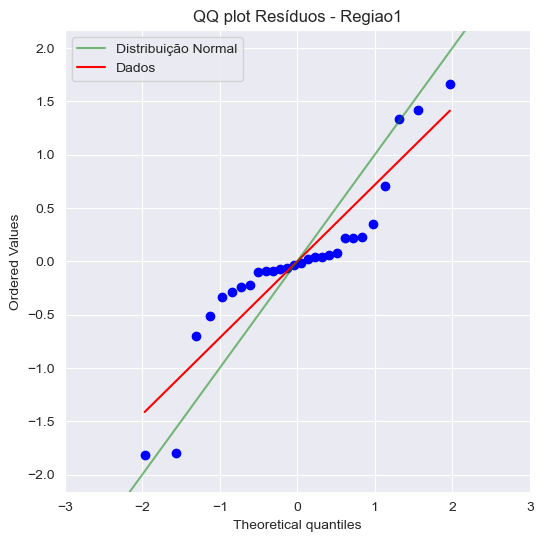

1


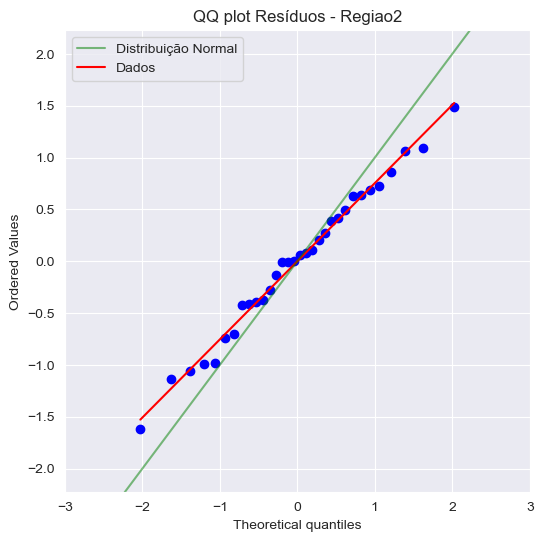

2


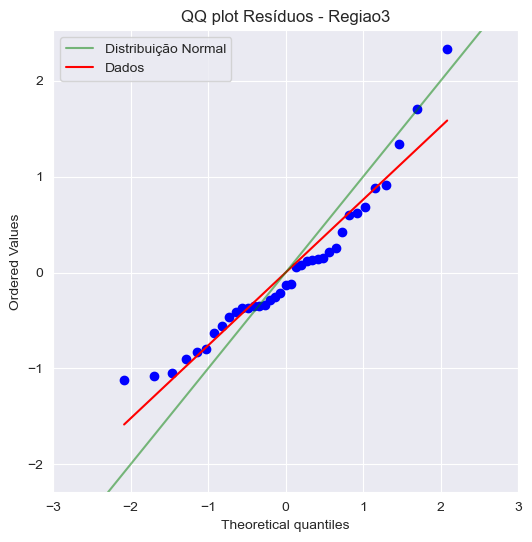

3


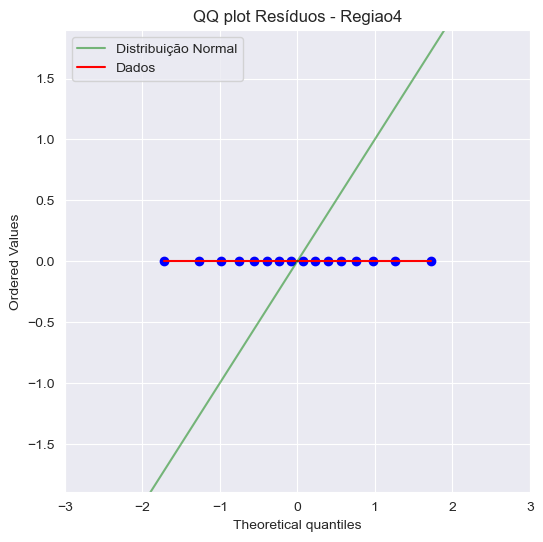

In [20]:
qq_plot_cat(df, err)